# DM - Classification [TASK 3]

Library imports and initial settings.

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

import pydotplus
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import cross_validate
import statistics
import itertools

from utils import fetch_preprocessed_dataset, store_preprocessed_dataset, build_grid_plot

import sys
import logging as lg

root = lg.getLogger()
root.setLevel(lg.INFO)

handler = lg.StreamHandler(sys.stdout)
handler.setLevel(lg.DEBUG)
formatter = lg.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
handler.setFormatter(formatter)
root.addHandler(handler)

Fetching users dataset saved in data preparation phase.

In [2]:
# Load the users dataset from pickle
dataset = fetch_preprocessed_dataset(step_name="users_total")
users = dataset['users.pickle']

`users_num` is a dataset composed by numerical attributes of `users`.

In [3]:
users_num_cols = ['statuses_count', 'bot', 'tweets_num', 'tweets_2020_num', 'likes_num', 'comments_num', 'ratio_likes_x_tweets', 'entropy', 'texts_mean_length', 'texts_special_chars_length', 'mean_pub_range', 'mean_texts_similarity']

users_num = users[users_num_cols].astype({'bot': 'int64'})
langs_map = {lang: i for i, lang in enumerate(sorted(users['lang'].unique()))}
users_num['lang_num'] = users['lang'].map(langs_map).astype('int64')

users_num.info

<bound method DataFrame.info of        statuses_count  bot  tweets_num  tweets_2020_num  likes_num  \
0                  76    1         118              118        5.0   
1                  54    0         104              104        6.0   
2                   3    1           3                3        0.0   
3                  50    1        1253             1253      240.0   
4                7085    0        3217             3217      207.0   
...               ...  ...         ...              ...        ...   
11503            1126    0         991              991       61.0   
11504            3024    0        1853             1853      426.0   
11505               6    0           6                6        0.0   
11506              42    1          91               91        8.0   
11507            5279    0        3301             3301      439.0   

       comments_num  ratio_likes_x_tweets   entropy  texts_mean_length  \
0               0.0              0.042373  0.000192  

## Dataset preparation

Splitting dataset in training and test set. Each of the two part is a couple of input values and labels.

In [4]:
dataset = users_num.copy()
label = dataset.pop('bot')
train_set, test_set, train_label, test_label = train_test_split(dataset, label, stratify =label, test_size=0.20)

print("train_set:", train_set.shape)
print("train_label:", train_label.shape)
print("test_set:", test_set.shape)
print("test_label:", test_label.shape)

train_set: (9206, 12)
train_label: (9206,)
test_set: (2302, 12)
test_label: (2302,)


## Classification models

### Decision tree

In [105]:
def create_dt(max_depth, min_samples_leaf):
    return tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=max_depth, min_samples_leaf=min_samples_leaf)

In [109]:
def dt_gridsearch(train_set, train_label, params):
    best_test_score = None
    best_params = {}
    for max_depth, min_samples_leaf in params:
        dt = create_dt(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        dt = dt.fit(train_set, train_label)

        scores = cross_validate(dt, train_set, train_label, cv=4)
        new_test_score = statistics.mean(scores['test_score'])
        if best_test_score is None or new_test_score > best_test_score:
            best_test_score = new_test_score
            best_params = {
                "max_depth": max_depth,
                "min_samples_leaf": min_samples_leaf
            }
    return best_test_score, best_params

In [113]:
max_depths = [5, 10, 20, 30, 40, 50]
min_samples_leafs = [1, 2, 3, 4, 5]

params = itertools.product(max_depths, min_samples_leafs)

best_test_score, best_params = dt_gridsearch(train_set, train_label, params=params)

best_test_score, best_params

(0.8210962275684919, {'max_depth': 10, 'min_samples_leaf': 3})

In [114]:
dt = create_dt(best_params['max_depth'], best_params['min_samples_leaf'])
dt.fit(train_set, train_label)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=3)

In [121]:
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

In [126]:
def report_scores(train_pred, test_pred, tr_label=train_label, ts_label=test_label):
    print("TRAIN")
    print(metrics.classification_report(tr_label,
                            train_pred,
                            target_names=['user', 'bot']))
    print("TEST")
    print(metrics.classification_report(ts_label,
                            test_pred,
                            target_names=['user', 'bot']))

In [141]:
report_scores(train_pred_dt, test_pred_dt)

TRAIN
              precision    recall  f1-score   support

        user       0.96      0.73      0.83      4313
         bot       0.81      0.98      0.88      4893

    accuracy                           0.86      9206
   macro avg       0.89      0.86      0.86      9206
weighted avg       0.88      0.86      0.86      9206

TEST
              precision    recall  f1-score   support

        user       0.92      0.71      0.80      1079
         bot       0.79      0.95      0.86      1223

    accuracy                           0.83      2302
   macro avg       0.85      0.83      0.83      2302
weighted avg       0.85      0.83      0.83      2302



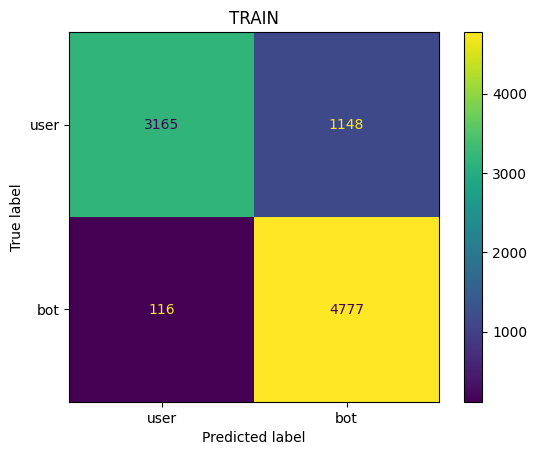

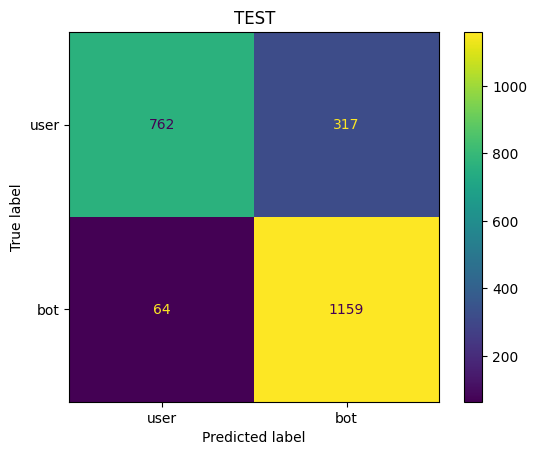

In [140]:
def plot_cms(train_pred, test_pred, tr_label=train_label, ts_label=test_label):
    def plot_cm(title, label, pred):
        cm = metrics.confusion_matrix(label, pred)
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['user', 'bot'])
        disp.plot()
        disp.ax_.set_title(title)

    plot_cm("TRAIN", tr_label, train_pred)
    plot_cm("TEST", ts_label, test_pred)

plot_cms(train_pred_dt, test_pred_dt)